In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stock_pandas import StockDataFrame as SDF
from stockstats import StockDataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset - daily

In [2]:
df = pd.read_csv("../DataSets/BTC-USD.csv")
df = df.dropna()
del df['High']
del df['Low']
del df['Adj Close']
del df['Volume']
df

,Date,Open,Close
0,9/17/14,465.864014,457.334015
1,9/18/14,456.859985,424.440002
2,9/19/14,424.102997,394.795990
3,9/20/14,394.673004,408.903992
4,9/21/14,408.084991,398.821014
...,...,...,...
3135,4/18/23,29449.091800,30397.552730
3136,4/19/23,30394.187500,28822.679690
3137,4/20/23,28823.683590,28245.988280
3138,4/21/23,28249.230470,27276.910160


In [3]:
sdf = StockDataFrame.retype(df)
sdf

,open,close
date,,
9/17/14,465.864014,457.334015
9/18/14,456.859985,424.440002
9/19/14,424.102997,394.795990
9/20/14,394.673004,408.903992
9/21/14,408.084991,398.821014
...,...,...
4/18/23,29449.091800,30397.552730
4/19/23,30394.187500,28822.679690
4/20/23,28823.683590,28245.988280


In [4]:
#Check that date is the index
print(sdf.index)

Index(['9/17/14', '9/18/14', '9/19/14', '9/20/14', '9/21/14', '9/22/14',
       '9/23/14', '9/24/14', '9/25/14', '9/26/14',
       ...
       '4/13/23', '4/14/23', '4/15/23', '4/16/23', '4/17/23', '4/18/23',
       '4/19/23', '4/20/23', '4/21/23', '4/22/23'],
      dtype='object', name='date', length=3140)


## BB

In [5]:
#Bollinger Bands Middle, Upper, Lower
bbs_m= sdf.get('boll')
bbs_u= sdf.get('boll_ub')
bbs_l=sdf.get('boll_lb')

df['BB_Upper'] = bbs_u
df['BB_Mid'] = bbs_m
df['BB_Low'] = bbs_l

## Reorder data

In [6]:
df = df.dropna()
new_order = ['open', 'BB_Upper', 'BB_Mid', 'BB_Low', 'close']
df = df.reindex(columns=new_order)

In [7]:
df

,open,BB_Upper,BB_Mid,BB_Low,close
date,,,,,
9/18/14,456.859985,487.406168,440.887008,394.367849,424.440002
9/19/14,424.102997,488.089504,425.523336,362.957167,394.795990
9/20/14,394.673004,475.088945,421.368500,367.648055,408.903992
9/21/14,408.084991,467.565274,416.859003,366.152731,398.821014
9/22/14,399.100006,461.323696,414.407837,367.491977,402.152008
...,...,...,...,...,...
4/18/23,29449.091800,31179.228064,29044.891894,26910.555725,30397.552730
4/19/23,30394.187500,31168.552134,29084.347754,27000.143374,28822.679690
4/20/23,28823.683590,31173.681927,29072.722949,26971.763971,28245.988280


## Dataset Summary

In [8]:
df_chart = df.copy()

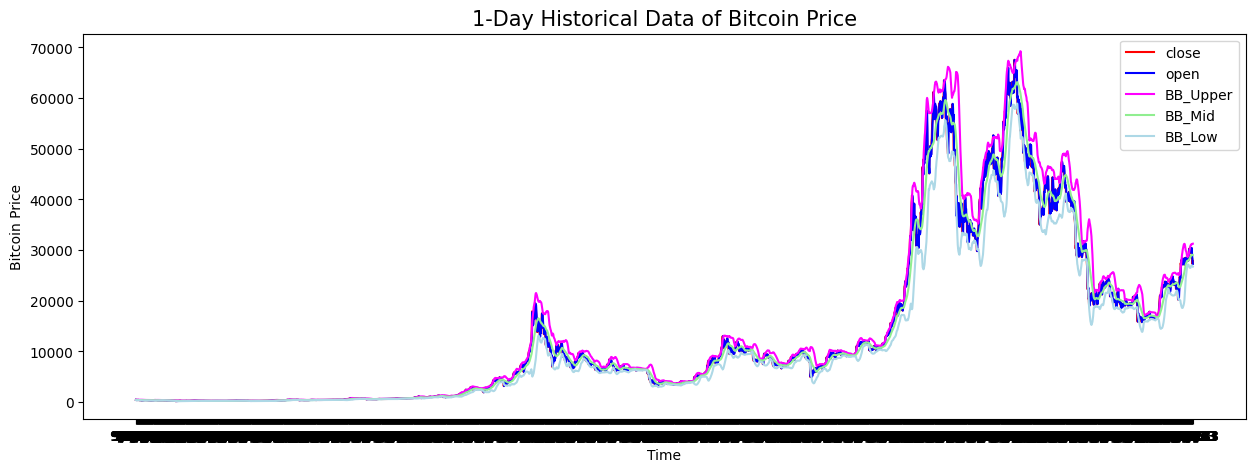

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['close'], color='red', label='close')
plt.plot(df_chart.index, df_chart['open'], color='blue', label='open')
plt.plot(df_chart.index, df_chart['BB_Upper'], color='magenta', label='BB_Upper')
plt.plot(df_chart.index, df_chart['BB_Mid'], color='lightgreen', label='BB_Mid')
plt.plot(df_chart.index, df_chart['BB_Low'], color='lightblue', label='BB_Low')
plt.title('1-Day Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

plt.show()

## Data featuring

In [10]:
feature_df = df.iloc[:,0:df.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features = scaler.fit_transform(feature_df.iloc[:,0:df.shape[1]-1].values)
scaled_targets = scaler.fit_transform(feature_df.iloc[:,df.shape[1]-1:df.shape[1]].values)

df_ft = pd.DataFrame(columns=feature_df.columns[0:df.shape[1]-1],
                         data=scaled_features,
                         index=feature_df.index)

df_y = pd.DataFrame(columns=feature_df.columns[df.shape[1]-1:df.shape[1]],
                         data=scaled_targets,
                         index=feature_df.index)

In [11]:
df_ft

,open,BB_Upper,BB_Mid,BB_Low
date,,,,
9/18/14,0.004155,0.003600,0.003409,0.003818
9/19/14,0.003669,0.003610,0.003165,0.003284
9/20/14,0.003232,0.003421,0.003099,0.003363
9/21/14,0.003431,0.003312,0.003027,0.003338
9/22/14,0.003298,0.003222,0.002988,0.003361
...,...,...,...,...
4/18/23,0.434481,0.448272,0.457997,0.455059
4/19/23,0.448509,0.448117,0.458624,0.456583
4/20/23,0.425198,0.448191,0.458439,0.456100


In [12]:
df_y

,close
date,
9/18/14,0.003655
9/19/14,0.003216
9/20/14,0.003425
9/21/14,0.003275
9/22/14,0.003325
...,...
4/18/23,0.448435
4/19/23,0.425065
4/20/23,0.416507


In [13]:
def lstm_split(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df.shape[1]-1])
        y.append(target[i:i+1, -1])
    return np.array(X), np.array(y)

def lstm_split2(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df2.shape[1]-1])
    return np.array(X)

In [14]:
n_steps = 100
X1, y1 = lstm_split(df_ft.values, df_y.values, n_steps)

In [15]:
print(X1.shape, y1.shape)

(3040, 100, 4) (3040, 1)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [17]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2128, 100, 4) (2128, 1) (912, 100, 4) (912, 1)


## LSTM model

In [18]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M2


## model Summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          42000     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          60400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                3

In [20]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


2023-04-23 19:37:01.535851: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 6s 43ms/step - loss: 0.0182
Epoch 2/50
67/67 [==============================] - 3s 46ms/step - loss: 0.0124
Epoch 3/50
67/67 [==============================] - 3s 48ms/step - loss: 0.0079
Epoch 4/50
67/67 [==============================] - 3s 39ms/step - loss: 0.0064
Epoch 5/50
67/67 [==============================] - 3s 45ms/step - loss: 0.0049
Epoch 6/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0038
Epoch 7/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0040
Epoch 8/50
67/67 [==============================] - 3s 43ms/step - loss: 0.0026
Epoch 9/50
67/67 [==============================] - 3s 42ms/step - loss: 0.0022
Epoch 10/50
67/67 [==============================] - 3s 42ms/step - loss: 0.0017
Epoch 11/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0020
Epoch 12/50
67/67 [==============================] - 3s 39ms/step - loss: 0.0015
Epoch 13/50
67/67 [=============================

## Evaluate

In [21]:
y_pred = model.predict(X_test)

29/29 [==============================] - 2s 15ms/step


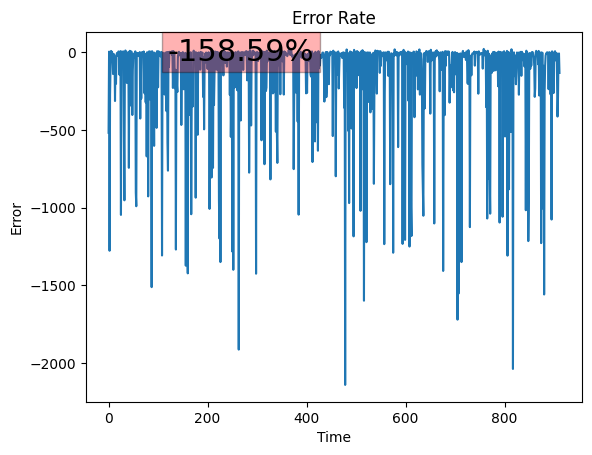

In [22]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

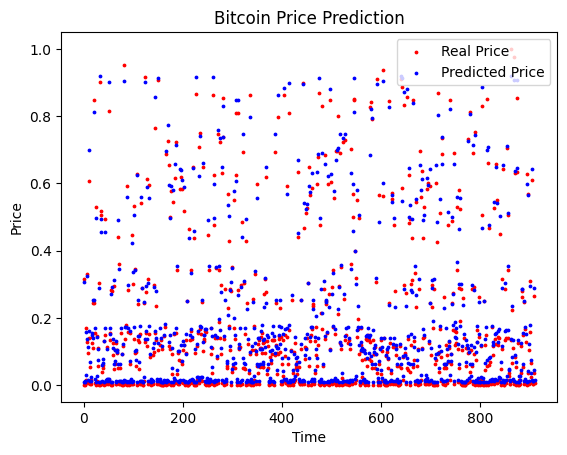

In [23]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Predicting Today's closing price
## To predict today's price, you need to download at least n_step previous data

In [42]:
df2 = pd.read_csv("../DataSets/BTC-USD2.csv")
df2 = df2.dropna()
del df2['High']
del df2['Low']
del df2['Adj Close']
del df2['Volume']

In [43]:
df2

,Date,Open,Close
0,2023-01-13,18868.906250,19909.574219
1,2023-01-14,19910.537109,20976.298828
2,2023-01-15,20977.484375,20880.798828
3,2023-01-16,20882.224609,21169.632813
4,2023-01-17,21175.833984,21161.519531
...,...,...,...
95,2023-04-18,29449.091797,30397.552734
96,2023-04-19,30394.187500,28822.679688
97,2023-04-20,28823.683594,28245.988281
98,2023-04-21,28249.230469,27276.910156


In [44]:
Open = 27804.27
TODAY = pd.DataFrame({'Date': ['2023-04-23'], 
                            'Open': [Open], 
                            'Close': [np.nan]})

In [45]:
TODAY

,Date,Open,Close
0,2023-04-23,27804.27,NaN


In [46]:
df2 = pd.concat([df2, TODAY], ignore_index=True)

In [47]:
sdf2 = StockDataFrame.retype(df2)
sdf2

,open,close
date,,
2023-01-13,18868.906250,19909.574219
2023-01-14,19910.537109,20976.298828
2023-01-15,20977.484375,20880.798828
2023-01-16,20882.224609,21169.632813
2023-01-17,21175.833984,21161.519531
...,...,...
2023-04-19,30394.187500,28822.679688
2023-04-20,28823.683594,28245.988281
2023-04-21,28249.230469,27276.910156


## BB

In [48]:
bbs_m= sdf2.get('boll')
bbs_u= sdf2.get('boll_ub')
bbs_l=sdf2.get('boll_lb')
df2['BB_Upper'] = bbs_u
df2['BB_Mid'] = bbs_m
df2['BB_Low'] = bbs_l

In [49]:
new_order2 = ['open', 'BB_Upper', 'BB_Mid', 'BB_Low', 'close']
df2 = df2.iloc[1:df2.shape[0],:]
df2 = df2.reindex(columns=new_order2)
df2

,open,BB_Upper,BB_Mid,BB_Low,close
date,,,,,
2023-01-14,19910.537109,21951.512933,20442.936524,18934.360114,20976.298828
2023-01-15,20977.484375,21769.370438,20588.890625,19408.410812,20880.798828
2023-01-16,20882.224609,21859.368674,20734.076172,19608.783670,21169.632813
2023-01-17,21175.833984,21866.407082,20819.564844,19772.722606,21161.519531
2023-01-18,21161.050781,21740.161252,20797.767578,19855.373905,20688.781250
...,...,...,...,...,...
2023-04-19,30394.187500,31168.552136,29084.347754,27000.143372,28822.679688
2023-04-20,28823.683594,31173.681929,29072.722949,26971.763970,28245.988281
2023-04-21,28249.230469,31249.231841,29016.016699,26782.801557,27276.910156


In [50]:
df2.shape[0]

100

In [51]:
feature_df2 = df2.iloc[:,0:df2.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features2 = scaler.fit_transform(feature_df2.iloc[:,0:df2.shape[1]-1].values)
scaled_targets2 = scaler.fit_transform(feature_df2.iloc[:,df2.shape[1]-1:df2.shape[1]].values)

df_ft2 = pd.DataFrame(columns=feature_df2.columns[0:df2.shape[1]-1],
                         data=scaled_features2,
                         index=feature_df2.index)

df_y2 = pd.DataFrame(columns=feature_df2.columns[df2.shape[1]-1:df2.shape[1]],
                         data=scaled_targets2,
                         index=feature_df2.index)

In [52]:
df_ft2

,open,BB_Upper,BB_Mid,BB_Low
date,,,,
2023-01-14,0.000000,0.023341,0.000000,0.042376
2023-01-15,0.100844,0.004434,0.016890,0.097708
2023-01-16,0.091840,0.013776,0.033691,0.121095
2023-01-17,0.119591,0.014507,0.043584,0.140230
2023-01-18,0.118194,0.001402,0.041062,0.149877
...,...,...,...,...
2023-04-19,0.990873,0.980094,1.000000,0.983818
2023-04-20,0.842435,0.980627,0.998655,0.980506
2023-04-21,0.788140,0.988469,0.992093,0.958450


In [53]:
X2 = lstm_split2(df_ft2.values, n_steps)

In [54]:
X2.shape

(1, 100, 4)

In [55]:
y_today = model.predict(X2)

1/1 [==============================] - 0s 114ms/step


In [56]:
y_today.shape

(1, 1)

In [57]:
y_today_original = scaler.inverse_transform(y_today)

In [58]:
y_today_original

array([[22505.938]], dtype=float32)

In [59]:
Today = y_today_original.astype(np.float32)

## Fee calculating
based on biance trading fees(0.1%)

In [60]:
buying_fee = Open * 0.001
selling_fee = Today * 0.001
fees = buying_fee + selling_fee
if (Open > Today + fees):
    print("stay")
elif (Open > Today + fees):
    print("You can earn money today: ", ((Today + fees)-Open)/Open*100, "%")

stay
